In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Loading data and prining out head & shape ###

In [22]:
#Importing data to dataframe
raw_data = pd.read_csv('data.csv')
print(raw_data.head().to_string())
print("Shape: ", raw_data.shape)

   resultId  raceId  year  round  grid  positionOrder  points  laps milliseconds fastestLap rank fastestLapTime fastestLapSpeed        driverRef     surname forename         dob nationality_x constructorRef                          name nationality_y     circuitRef  circuitId        name_y    location  country      lat        lng  alt        date  target_finish
0      2460     136  2002     13    11              4     3.0  77.0          NaN         \N   \N             \N              \N        raikkonen   Räikkönen     Kimi  1979-10-17       Finnish        mclaren                   Hungaroring       British    hungaroring         11       McLaren    Budapest  Hungary  47.5789   19.24860  264  2002-08-18              1
1     11565     483  1981      1    23             21     0.0  16.0           \N         \N   \N             \N              \N           watson      Watson     John  1946-05-04       British        mclaren                    Long Beach       British     long_beach       

### Print overview of columns containing NA values, and dropping using 90% threshold ###

In [23]:
# Make sure other types of missing data is also registered as missing data
missing_markers = ['\\N', 'NULL', 'null', ''] 
raw_data = raw_data.replace(missing_markers, np.nan)

nullValues = raw_data.isnull().sum()
print("Rows with NA and NA count: ")
print(nullValues[nullValues > 0])
print("\nShape with 90% threshold for dropping column:")
thresh = round(0.9*raw_data.shape[0])
trimmed_raw_data = raw_data.dropna(axis=1, thresh=thresh)
print(trimmed_raw_data.shape)
print(trimmed_raw_data.columns)

Rows with NA and NA count: 
points              971
laps                978
milliseconds       7393
fastestLap         6895
rank               6798
fastestLapTime     6895
fastestLapSpeed    7191
dtype: int64

Shape with 90% threshold for dropping column:
(10000, 26)
Index(['resultId', 'raceId', 'year', 'round', 'grid', 'positionOrder',
       'points', 'laps', 'driverRef', 'surname', 'forename', 'dob',
       'nationality_x', 'constructorRef', 'name', 'nationality_y',
       'circuitRef', 'circuitId', 'name_y', 'location', 'country', 'lat',
       'lng', 'alt', 'date', 'target_finish'],
      dtype='object')


### Further feature selection ###
Some columns have leakage features, meaning they have a 1-1 correlation with what we try to predict.These need to be removed as they will make the predictions too "easy". Some of these are also measurements made after after the target value is measured, and therefore don't have any predictive power. E.g. "positionOrder" and "points", which are based upon whether the driver finishes the race or not. <br>
Will keep features 'year', 'round', 'grid', 'constructorRef', 'circuitRef', 'alt', 'date' as well as 'target_finish' <br>
Reasons one by one: <br><br>

##### Id's #####
- resultId: DROP – not useful

- raceId: DROP – not useful

- circuitId: DROP – Redundant with circuitRef

##### Race metadata #####

- year: KEEP – DNF rates may vary over the years

- round: KEEP – Early/late season influences DNF

- date: KEEP – Weather/season patterns

- country: DROP - redundant with circuitRef

##### Driver & team #####

- driverRef: DROP - High cardinality, too sparse. Data of retired drivers unuseful for future drivers

- surname: DROP – same reason as driverRef

- forename: DROP – same reason as driverRef

- dob: DROP – weak predictor

- nationality_x: DROP – Weak predictor

- constructorRef: KEEP – Team strongly impacts DNF

- nationality_y: DROP – irrelevant / redundant to constructorRef

##### Performance stats #####

- grid: KEEP – Starting position affects crash risk

- positionOrder: DROP – Leakage (reveals final result)

##### Circuit info #####

- circuitRef: KEEP – Tracks differ in DNF probability

- name: DROP – Duplicate of circuitRef

- name_y: DROP – Another duplicate

- location: DROP – Text field, not useful

##### Geographical #####

- lat: DROP – Raw coordinate not meaningful

- lng: DROP – Same as above

- alt: KEEP - altitude of tracks may be predicitive  


In [24]:
keep_cols = [
    'year', 'round', 'grid', 'constructorRef',
    'circuitRef', 'alt', 'date',
    'target_finish'
]
clean_data = trimmed_raw_data[keep_cols]
print("Shape:", clean_data.shape)
print("Features:",clean_data.columns)

Shape: (10000, 8)
Features: Index(['year', 'round', 'grid', 'constructorRef', 'circuitRef', 'alt', 'date',
       'target_finish'],
      dtype='object')


### Dropping rows with NA values (redundant as columns containing NA are removed already) ###

In [25]:
clean_data = clean_data.dropna()
print("Shape after dropping rows with NA values and columns with >90% NA values:\n",clean_data.shape)

Shape after dropping rows with NA values and columns with >90% NA values:
 (10000, 8)


### Printing out describtion of dataframe, and ranked correlation between numerical features for analysis ###

In [26]:
print(clean_data.describe().to_string())
print("\nCorrelation between numerical features and target_finish ranked on abs value")
print(clean_data.corr(numeric_only=True)['target_finish'].sort_values(key=abs, ascending=False)[1:])

               year         round          grid           alt  target_finish
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000
mean    1991.466600      8.540100     11.176200    281.465900       0.289500
std       20.060237      5.085487      7.241008    414.586363       0.453553
min     1950.000000      1.000000      0.000000     -7.000000       0.000000
25%     1977.000000      4.000000      5.000000     18.000000       0.000000
50%     1991.000000      8.000000     11.000000    153.000000       0.000000
75%     2009.000000     12.000000     17.000000    401.000000       1.000000
max     2024.000000     24.000000     34.000000   2227.000000       1.000000

Correlation between numerical features and target_finish ranked on abs value
grid    -0.344964
year     0.276936
round    0.123115
alt     -0.043222
Name: target_finish, dtype: float64


### Handling 'object' values ###

Will use a reduced One Hot Encoding. Let the top 10 most common values per feature be one hot encoded, place all other values under a group called 'other...'

Then convert date to month, and OHE it

In [27]:
clean_data["date"] = pd.to_datetime(clean_data["date"]).dt.month
clean_data = clean_data.rename(columns={"date":"month"})

In [28]:
top_10_constructorRefs = clean_data['constructorRef'].value_counts().nlargest(10).index

print("The Top 10 constructorRefs are:", list(top_10_constructorRefs))

# Replace country if not in top 10 with 'Other'
clean_data['constructorRef'] = clean_data['constructorRef'].apply(
    lambda x: x if x in top_10_constructorRefs else 'other_const'
)

The Top 10 constructorRefs are: ['ferrari', 'mclaren', 'williams', 'sauber', 'team_lotus', 'tyrrell', 'red_bull', 'renault', 'ligier', 'brabham']


In [29]:
top_10_circuitRef = clean_data['circuitRef'].value_counts().nlargest(10).index

print("The Top 10 circuitRef are:", list(top_10_circuitRef))

# Replace country if not in top 10 with 'Other'
clean_data['circuitRef'] = clean_data['circuitRef'].apply(
    lambda x: x if x in top_10_circuitRef else 'other_circ'
)

The Top 10 circuitRef are: ['monza', 'monaco', 'silverstone', 'spa', 'villeneuve', 'hungaroring', 'nurburgring', 'hockenheimring', 'interlagos', 'red_bull_ring']


### Dataset before OHE ###

In [30]:
print(clean_data.head().to_string())

   year  round  grid constructorRef     circuitRef  alt  month  target_finish
0  2002     13    11        mclaren    hungaroring  264      8              1
1  1981      1    23        mclaren     other_circ   12      3              0
2  1958      8     0    other_const    nurburgring  578      8              0
3  2021      8    19    other_const  red_bull_ring  678      6              0
4  1988     12     0    other_const          monza  162      9              0


In [31]:
from sklearn.preprocessing import OneHotEncoder

cat = ["constructorRef", "circuitRef", "month"]
enc = OneHotEncoder()
enc.fit(clean_data[cat])
cat_data = enc.transform(clean_data[cat]).toarray()

cat_df = pd.DataFrame(data = cat_data, columns = enc.get_feature_names_out(), index = clean_data.index)
encoded_data = clean_data.join(cat_df).drop(columns = cat)

# Dropped to avoid linear dependencies 
encoded_data = encoded_data.drop(columns=["circuitRef_other_circ", "constructorRef_other_const", "month_12"])

### Dataset after OHE ###

In [32]:
print(encoded_data.head().to_string())
print(encoded_data.shape)
print(encoded_data.columns)

   year  round  grid  alt  target_finish  constructorRef_brabham  constructorRef_ferrari  constructorRef_ligier  constructorRef_mclaren  constructorRef_red_bull  constructorRef_renault  constructorRef_sauber  constructorRef_team_lotus  constructorRef_tyrrell  constructorRef_williams  circuitRef_hockenheimring  circuitRef_hungaroring  circuitRef_interlagos  circuitRef_monaco  circuitRef_monza  circuitRef_nurburgring  circuitRef_red_bull_ring  circuitRef_silverstone  circuitRef_spa  circuitRef_villeneuve  month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  month_11
0  2002     13    11  264              1                     0.0                     0.0                    0.0                     1.0                      0.0                     0.0                    0.0                        0.0                     0.0                      0.0                        0.0                     1.0                    0.0                0.0               

## Flip values in target_finish ## 
We want to detect DNF, make this our positive

In [36]:
encoded_data['target_dnf'] = 1 - encoded_data['target_finish']
encoded_data = encoded_data.drop(columns=["target_finish"])
print(encoded_data["target_dnf"].value_counts())

target_dnf
1    7105
0    2895
Name: count, dtype: int64


## Data split ##

cutoff_year set to 2015 arbitrarily for now. Can change this, but gives a reasonable split (test size ~15% of dataset)

In [37]:
cutoff_year = 2015

train_data = encoded_data[encoded_data['year'] <= cutoff_year].copy()
test_data  = encoded_data[encoded_data['year'] >  cutoff_year].copy()

X_train = train_data.drop(columns=['target_dnf'])
y_train = train_data['target_dnf']

X_test  = test_data.drop(columns=['target_dnf'])
y_test  = test_data['target_dnf']

print("Training size (X, y):", X_train.shape, ",", len(y_train))
print("Test size (X, y):", X_test.shape, ",", len(y_test))

Training size (X, y): (8550, 35) , 8550
Test size (X, y): (1450, 35) , 1450


# Random Forest #

### Helper functions ###

In [38]:
def get_param_order(param_grid):
    param0 = [key for key, value in param_grid.items() if len(value) == 2]
    param1 = param_grid.keys() - param0
    return [param0[0],param1.pop()]

def unpack_gridsearch(gs):

    param_grid = gs.param_grid
    result = gs.cv_results_
    
    cols = ['mean_test_score']
        
    param_order = get_param_order(param_grid)

    f0 = 'param_{}'.format(param_order[0])
    f1 = 'param_{}'.format(param_order[1])
    f0vals = param_grid[param_order[0]]
    f1vals = param_grid[param_order[1]]
    
    X = dict.fromkeys(f0vals)

    for f0val in f0vals:
        X[f0val] = pd.DataFrame(index=f1vals,columns=cols,dtype=float)

    for f0val in f0vals:
        for f1val in f1vals:
            ind = (result[f0]==f0val) & (result[f1]==f1val)
            for col in cols:
                X[f0val].loc[f1val,col] = float(result[col][ind][0])

    return { 'scoregrid':X, 
             'best_params':gs.best_params_, 
             'best_estimator':gs.best_estimator_, 
             'best_score':gs.best_score_,
             'param_grid':param_grid
            } 

def plot_grid_result(result,log=True):

    param_grid = result['param_grid']
    X = result['scoregrid']
    param_order = get_param_order(param_grid)
    cols = ['mean_test_score']
    labels = [' (accuracy)']
    colors = ['r','b']
    linestyles = ['--', '-']

    f0vals = param_grid[param_order[0]]

    plt.figure(figsize=(10,4))
    for f0ind, f0val in enumerate(f0vals):
        for c, col in enumerate(cols):
            if log:
                plt.semilogx(X[f0val][col],color=colors[c],linestyle=linestyles[f0ind],marker='o',label='{} {}'.format(f0val,labels[c]))
            else:
                plt.plot(X[f0val][col],color=colors[c],linestyle=linestyles[f0ind],marker='o',label='{} {}'.format(f0val,labels[c]))
    plt.legend(fontsize=12)
    plt.grid(':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def hypersolve(model,param_grid):
    # 1. Create the pipeline model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=3, 
        refit='accuracy'
    )
    
    # 3. Run the grid search
    gs = gs.fit(X_train, y_train)
    
    # 4. Run `unpack_gridsearch` to obtain the results dictionary.
    result = unpack_gridsearch(gs)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result)

    # 6. return result
    return result

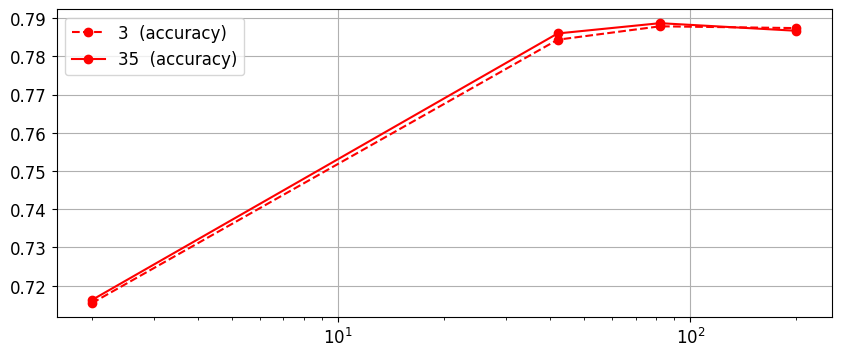

In [42]:
from sklearn.ensemble import RandomForestClassifier

rng_seed = 42

param_grid_rf = {
    'model__max_features' : [3, X_train.shape[1]],
    'model__n_estimators' : [2,42,82, 200]
}

model = RandomForestClassifier(random_state=rng_seed)

result_rf = hypersolve(model, param_grid_rf)

In [45]:
(y_train == 1).sum() / len(y_train), encoded_data["target_dnf"].sum() / encoded_data.shape[0]

(np.float64(0.752046783625731), np.float64(0.7105))

In [ ]:
# from sklearn.metrics import accuracy_score
# best_model = result_rf["best_estimator"]
# test_accuracy = accuracy_score(y_test, best_model.predict(X_test))